In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
import tensorflow as tf

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,        
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def hold_out(data, classes, clf, target_name=0, ratio=0.7, random_state=0):
    # Split Data
    y = data[target_name] # Target
    x = data.drop(target_name, axis=1) # Attribute
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, train_size=ratio, random_state=random_state) # ratio = 7:3

    # train Model
    clf.fit(train_x, train_y)
    # Predict
    pred = clf.predict(valid_x)

    # Display
    cl_labels = np.array(classes)

    print(classification_report(valid_y, pred, target_names=cl_labels))
    plot_confusion_matrix(valid_y, pred, classes=cl_labels, cmap=plt.cm.Blues)
    plt.show()

In [4]:
def tf_hold_out(data, classes, target_name=0, ratio=0.7, random_state=0):
    # Split Data
    y = data[target_name] # Target
    x = data.drop(target_name, axis=1) # Attribute
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, train_size=ratio, random_state=random_state) # ratio = 7:3

    # train Model
    clf = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='sigmoid'),
        tf.keras.layers.Dense(26, activation='sigmoid')
    ])

    clf.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    clf.fit(train_x, train_y, epochs=100)
    # Predict
    pred = clf.predict(valid_x)
    pred = [np.argmax(d) for d in pred]

    # Display
    cl_labels = np.array(classes)

    print(classification_report(valid_y, pred, target_names=cl_labels))
    plot_confusion_matrix(valid_y, pred, classes=cl_labels, cmap=plt.cm.Blues)
    plt.show()

In [5]:
def log_parse(file_path):
    all_tmp = []
    tmp = []
    with open(file_path, 'r') as log:
        for line in log:
            if line == '[START]\n':
                tmp = []
            elif line == '[END]\n':
                all_tmp.append(tmp)
            else:
                first = int(line.split()[0].split('(')[1].split(',')[0])
                second = int(line.split()[1].split(')')[0])
                tmp.append((first, second))

    return all_tmp


def get_log():
    alphabet = {
        'A': 3,
        'B': 2,
        'C': 1,
        'D': 2,
        'E': 4,
        'F': 3,
        'G': 2,
        'H': 3,
        'I': 3,
        'J': 2,
        'K': 3,
        'L': 1,
        'M': 4,
        'N': 3,
        'O': 1,
        'P': 2,
        'Q': 2,
        'R': 3,
        'S': 1,
        'T': 2,
        'U': 1,
        'V': 2,
        'W': 4,
        'X': 2,
        'Y': 3,
        'Z': 3
    }

    alphabet_data = []

    for ab in alphabet.keys():
        path = './log/' + ab
        log_list = os.listdir(path)
        for log_path in log_list:
            abs_log_path = path + '/' + log_path
            parse_log = log_parse(abs_log_path)
            alphabet_data.append([ab, parse_log])

    alphabet_data = pd.DataFrame(alphabet_data)

    # Check Strobe Number
    check_data = []
    for data in alphabet_data.values.tolist():
        if(alphabet[data[0]] == len(data[1])):
            check_data.append(data)
    alphabet_data = pd.DataFrame(check_data)

    alphabet_data.to_json('alphabet_strobe.json')

get_log()

In [6]:
strobe_data = pd.read_json('alphabet_strobe.json')
processed_data = []
for line in strobe_data.values.tolist():
    tmp = []
    tmp.append(line[0]) # Add Category

    big_pack = []
    for strobe in line[1]:
        # Clear Pack
        pack = []

        # Add slope (Radius)
        dx = strobe[-1][0] - strobe[0][0]
        dy = strobe[-1][1] - strobe[0][1]
        pack.append(math.atan2(dy, dx)) # Get Radius # Don't use dy/dx, the accuracy will be very bad
        
        # Add strobe's length
        length = 0
        last_point = -1
        for point in strobe :
            if (last_point == -1):
                last_point = point
            else :
                length += math.sqrt((point[0] - last_point[0])**2 + (point[1] - last_point[1])**2)
                last_point = point
        pack.append(length)

        # Add offset from first strobe's start
        f_s_start = line[1][0][0]
        c_s_start = strobe[0]
        offset = math.sqrt((f_s_start[0] - c_s_start[0])**2 + (f_s_start[1] - c_s_start[1])**2)
        pack.append(offset)

        # Add Total dy and dx compare to start of this strobe (for C, S, U ...)
        c_s_start = strobe[0]
        total_dy = 0
        total_dx = 0
        for point in strobe :
            total_dx += abs(point[0] - c_s_start[0])
            total_dy += abs(point[1] - c_s_start[1])
        pack.append(total_dx)
        pack.append(total_dy)

        # Add number of sign change of x and y
        c_sign_x = False # Init is negative
        c_sign_y = False # Init is negative
        nx = 0
        ny = 0
        last_point = -1
        for point in strobe:
            if last_point == -1:
                last_point = point
            else:
                sign_x = (point[0] - last_point[0] > 0)
                sign_y = (point[1] - last_point[1] > 0)
                if (c_sign_x != sign_x):
                    c_sign_x = sign_x
                    nx+=1
                if (c_sign_y != sign_y):
                    c_sign_y = sign_y
                    ny+=1
                last_point = point
        pack.append(nx)
        pack.append(ny)

        # Append big_pack
        big_pack.append(pack)

    # Append TMP
    tmp.append(big_pack)

    # Add Data into Processed Data
    processed_data.append(tmp)

# # Normalizatoin
for line in processed_data:
    # offset = line[1][0][0]
    length_adj = 1/line[1][0][1]
    for pack in line[1]:
        # pack[0] -= offset
        pack[0] *= abs(pack[0])
        pack[1] *= length_adj
        pack[2] *= length_adj
        pack[3] *= length_adj
        pack[4] *= length_adj

# Extend
data = []
for line in processed_data:
    tmp = []
    tmp.append(line[0]) # Category
    for pack in line[1]:
        tmp.extend(pack)
    data.append(tmp)
data = pd.DataFrame(data)

# NaN
data = data.fillna(0)

# Label Encode
le = LabelEncoder()
le.fit(data[0])
data[0] = le.transform(data[0])

classes = le.classes_


              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       1.00      0.89      0.94         9
           C       1.00      1.00      1.00         9
           D       0.89      1.00      0.94         8
           E       1.00      1.00      1.00         6
           F       1.00      0.40      0.57         5
           G       1.00      1.00      1.00         7
           H       1.00      1.00      1.00         7
           I       0.73      1.00      0.84         8
           J       1.00      0.95      0.97        19
           K       1.00      1.00      1.00         8
           L       1.00      1.00      1.00        12
           M       1.00      1.00      1.00         5
           N       1.00      1.00      1.00        13
           O       1.00      0.11      0.20         9
           P       1.00      1.00      1.00        11
           Q       0.36      1.00      0.53         4
           R       1.00    

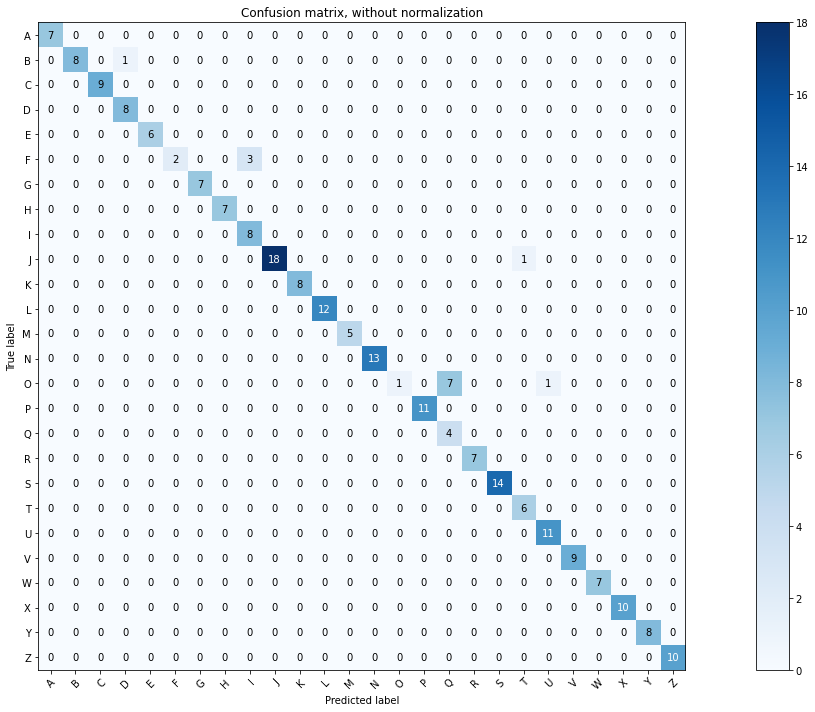

In [7]:
hold_out(data, classes, clf=svm.SVC(kernel='rbf'))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       1.00      1.00      1.00         9
           C       1.00      1.00      1.00        11
           D       1.00      1.00      1.00         7
           E       1.00      1.00      1.00         6
           F       1.00      1.00      1.00         5
           G       1.00      1.00      1.00         6
           H       1.00      1.00      1.00        11
           I       1.00      1.00      1.00        11
           J       1.00      1.00      1.00        14
           K       1.00      1.00      1.00        11
           L       1.00      1.00      1.00         6
           M       1.00      1.00      1.00         6
           N       1.00      1.00      1.00         5
           O       1.00      1.00      1.00         9
           P       1.00      1.00      1.00         9
           Q       1.00      1.00      1.00        11
           R       1.00    

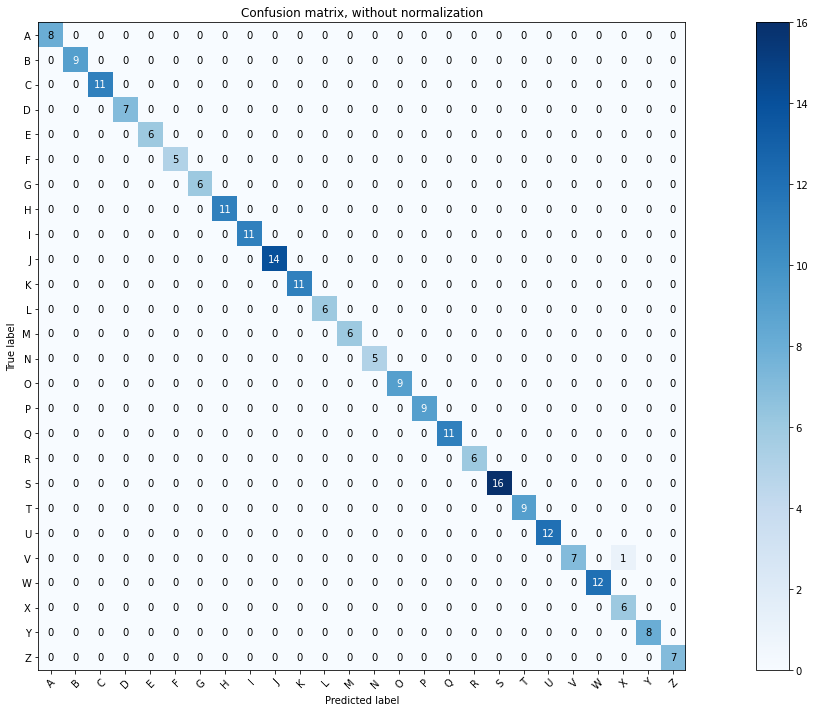

In [8]:
hold_out(data, classes, clf=ensemble.RandomForestClassifier(), random_state=None)


              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       1.00      1.00      1.00         9
           C       1.00      1.00      1.00         9
           D       1.00      1.00      1.00         8
           E       1.00      1.00      1.00         6
           F       0.80      0.80      0.80         5
           G       1.00      1.00      1.00         7
           H       1.00      1.00      1.00         7
           I       0.88      0.88      0.88         8
           J       1.00      0.95      0.97        19
           K       1.00      1.00      1.00         8
           L       1.00      1.00      1.00        12
           M       1.00      1.00      1.00         5
           N       1.00      1.00      1.00        13
           O       1.00      1.00      1.00         9
           P       1.00      1.00      1.00        11
           Q       1.00      1.00      1.00         4
           R       1.00    

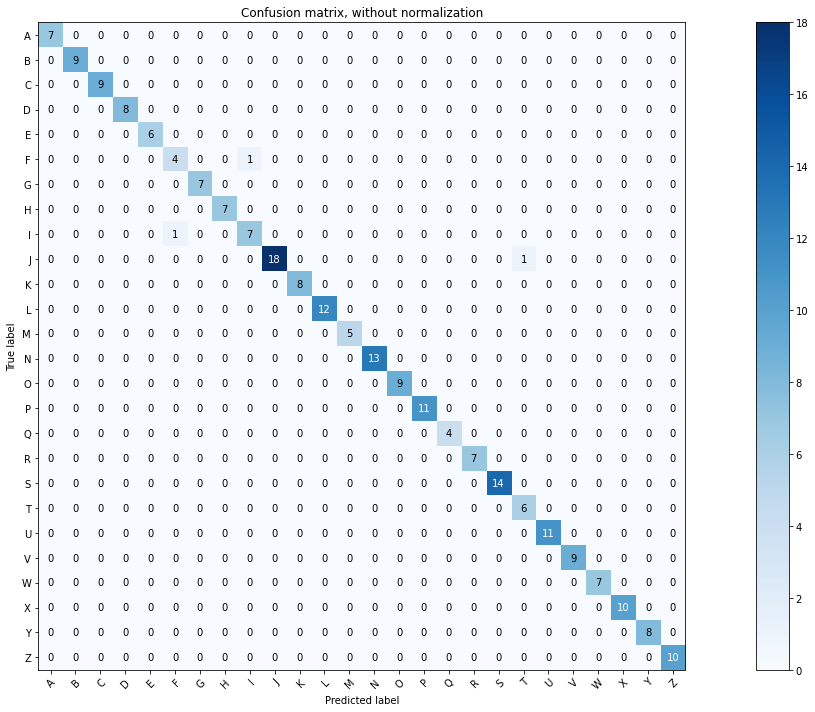

In [9]:
hold_out(data, classes, clf=neighbors.KNeighborsClassifier())


Epoch 1/100
17/17 [==============================] - 0s 3ms/step - loss: 3.3652 - accuracy: 0.0458
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 3.2621 - accuracy: 0.0711
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 3.1621 - accuracy: 0.0786
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 3.1028 - accuracy: 0.0831
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 2.9498 - accuracy: 0.1768
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 2.7389 - accuracy: 0.2480
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 2.5483 - accuracy: 0.2922
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 2.3556 - accuracy: 0.2887
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 2.1343 - accuracy: 0.3540
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 1.9168 - accuracy: 0.3663
Epoch 11/

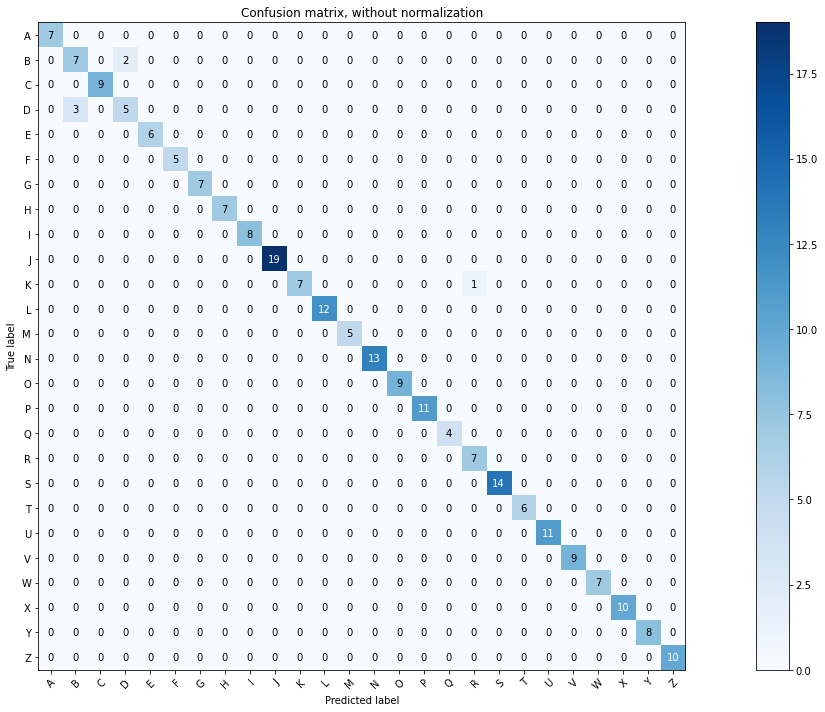

In [10]:
tf_hold_out(data, classes)

In [11]:
import joblib
clf=ensemble.RandomForestClassifier()
y = data[0] # Target
x = data.drop(0, axis=1) # Attribute
clf.fit(x, y)
joblib.dump(clf, 'strobe_classification.model')


['strobe_classification.model']

In [12]:
clf = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(26, activation='sigmoid')
])

clf.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

clf.fit(x, y, epochs=100)
clf.save('tf')


Epoch 1/100
24/24 [==============================] - 0s 2ms/step - loss: 3.4141 - accuracy: 0.0260
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 3.2495 - accuracy: 0.0536
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 3.1270 - accuracy: 0.1014
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 2.9310 - accuracy: 0.1666
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 2.6021 - accuracy: 0.2515
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 2.2713 - accuracy: 0.2843
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 2.0053 - accuracy: 0.4011
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 1.7686 - accuracy: 0.4362
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 1.5952 - accuracy: 0.5165
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 1.4208 - accuracy: 0.5772
Epoch 11/